In [1]:
import pandas as pd
import os

data_directory = './data/'

data_train = pd.read_csv(os.path.join(data_directory, 'train_stories.csv'), header='infer')
# print(data_train.columns)

data_val = pd.read_csv(os.path.join(data_directory, 'cloze_test_val__spring2016 - cloze_test_ALL_val.csv'), header='infer')
# print(data_val.columns)
# data_val.head()

In [2]:
import numpy as np

train_embeddings = np.load('/cluster/project/infk/courses/machine_perception_19/Sasglentamekaiedo/skip-thoughts-embbedings.npy')
validation_embeddings = np.load('/cluster/project/infk/courses/machine_perception_19/Sasglentamekaiedo/skip-thoughts-embbedings_validation.npy')

In [3]:
train_on_validation = True

if 'train_embeddings' in locals():
    print(train_embeddings.shape)
    train_on_validation = False
    
print(validation_embeddings.shape)

(88161, 5, 4800)
(1871, 6, 4800)


## Preprocess dataset

In [4]:
import tensorflow as tf
from sklearn.metrics import accuracy_score
from sklearn.utils import shuffle

/cluster/apps/python/3.6.4/lib64/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [5]:
# create dataset

v_embeddings = list()
v_classes = list()
correct_answers = data_val['AnswerRightEnding'].values

for i, story_embedding in enumerate(validation_embeddings):
    v_embeddings.append(np.append(story_embedding[:4], [story_embedding[4]], axis=0))
    v_embeddings.append(np.append(story_embedding[:4], [story_embedding[5]], axis=0))
    
    if correct_answers[i] == 1:
        v_classes.append(0)
        v_classes.append(1)
    else:
        v_classes.append(1)
        v_classes.append(0)
        
v_embeddings = np.array(v_embeddings)
v_classes = np.array(v_classes)

In [6]:
# split to train and test
from sklearn.utils import shuffle

if train_on_validation:
    train_size = 0.80

    np.random.seed(42)
    msk = np.random.rand(len(v_embeddings) // 2) < train_size
    new_mask = np.array([[value, value] for value in msk]).reshape(-1)

    train_embeddings, train_classes = shuffle(v_embeddings[new_mask], v_classes[new_mask])

    test_embeddings, test_classes = v_embeddings[~new_mask], v_classes[~new_mask]
else:
    train_embeddings, train_classes = shuffle(train_embeddings), np.zeros(len(train_embeddings))

    test_embeddings, test_classes = v_embeddings, v_classes

print('Train size:', len(train_embeddings))
print('Test size: ', len(test_embeddings))

Train size: 88161
Test size:  3742


In [7]:
def get_final_predictions(probabilities, threshold=1):
    # predictions based on probabilities!
    my_predictions = []

    probabilities_exp = np.exp(probabilities)

    i = 0
    while i < len(probabilities):
        p_first = probabilities_exp[i]
        p_second = probabilities_exp[i + 1]

        p1 = p_first[0] + p_second[1]
        p2 = p_first[1] + p_second[0]

        if p1 > p2 * threshold:
            my_predictions.append(0)
        else:
            my_predictions.append(1)
        i += 2

    return np.array(my_predictions)

In [12]:
import numpy as np

d1 = []
d2 = []
for emb, cl in zip(test_embeddings, test_classes):
    err = []
    for k in range(4):
        err.append(np.linalg.norm(emb[k] - emb[4]))
    err_mean = np.mean(err)
    
    if cl == 0:
        d1.append(err_mean)
    else:
        d2.append(err_mean)
        
print(np.mean(d1))
print(np.mean(d2))

1.0025446
1.008486


In [116]:
# parameters

BATCH_SIZE = 64
embedding_dim = train_embeddings.shape[-1]

units = 1024
num_labels = 2
NUM_EPOCHS = 200
NEGATIVE_SAMPLING = 3

NUM_SAMPLES_TRAINING = len(train_embeddings)
NUM_SAMPLES_VALIDATION = len(test_embeddings)

In [117]:
tf.reset_default_graph()

In [118]:
import random 


def sample_negatives(embeddings, embeddings_batch, classes_batch, negative_sampling):
    new_classes = []
    new_embeddings_batch = []
    for i, embedding in enumerate(embeddings_batch):

        new_embeddings_batch.append(embedding)
        new_classes.append(classes_batch[i])

        for _ in range(negative_sampling):
            new_embeddings_batch.append(
                np.concatenate((embedding[:4], [random.choice(embeddings[:, 4, :])]), axis=0))
            # negative class always
            new_classes.append(1)
    return np.array(new_embeddings_batch, dtype=np.float32), np.array(new_classes, dtype=np.int32)

def generator(train, batch_size=64, negative_sampling=0):
    """
    negative_sampling: For each positive sample these many negatives
    """
    if train:
        embeddings = train_embeddings
        classes = train_classes
    else:
        embeddings = test_embeddings
        classes = test_classes

    if train and negative_sampling > 0:
        batch_size /= (negative_sampling + 1)
        if batch_size != int(batch_size):
            raise Exception('Batch size should be an integer. Please change negative sampling rate')

        batch_size = int(batch_size)

    # repeat
    while(True):
        if train:
            embeddings, classes = shuffle(embeddings, classes)

        length = len(embeddings)
        for ndx in range(0, length, batch_size):
            embeddings_batch = embeddings[ndx: min(ndx + batch_size, length)]
            classes_batch = classes[ndx: min(ndx + batch_size, length)]

            if negative_sampling <= 0:
                yield embeddings_batch, classes_batch
            else:
                yield sample_negatives(embeddings, embeddings_batch, classes_batch, negative_sampling)

def create_dataset(train, batch_size, negative_sampling):
    dataset = tf.data.Dataset.from_generator(generator, (tf.float32, tf.int32), 
                                             output_shapes=(tf.TensorShape([None, 5, 4800]), tf.TensorShape([None])), 
                                             args = ([train, batch_size, negative_sampling]))

    iterator = dataset.make_one_shot_iterator()
    return iterator.get_next()


if train_on_validation:
    print('Loading without negative sampling')
    dataset_train = tf.data.Dataset.from_tensor_slices((train_embeddings, train_classes))
    dataset_train = dataset_train.shuffle(buffer_size=len(train_embeddings))

    dataset_train = dataset_train.repeat()
    dataset_train = dataset_train.batch(BATCH_SIZE)

    iterator_train = dataset_train.make_one_shot_iterator()
    train_X, train_y = iterator_train.get_next()

    dataset_test = tf.data.Dataset.from_tensor_slices((test_embeddings, test_classes))

    dataset_test = dataset_test.repeat()
    dataset_test = dataset_test.batch(BATCH_SIZE)

    iterator_test = dataset_test.make_one_shot_iterator()
    test_X, test_y = iterator_test.get_next()
else:
    train_X, train_y = create_dataset(True, BATCH_SIZE, NEGATIVE_SAMPLING)

    test_X, test_y = create_dataset(False, BATCH_SIZE, 0)

Loading without negative sampling


In [119]:
print(train_X)
print(train_y)
print()
print(test_X)
print(test_y)

Tensor("IteratorGetNext:0", shape=(?, 5, 4800), dtype=float32)
Tensor("IteratorGetNext:1", shape=(?,), dtype=int64)

Tensor("IteratorGetNext_1:0", shape=(?, 5, 4800), dtype=float32)
Tensor("IteratorGetNext_1:1", shape=(?,), dtype=int64)


In [120]:
# p = np.zeros(BATCH_SIZE*5*4800)
# with tf.Session() as sess:
#     while True:
#         x = sess.run(train_X)
#         x = x.reshape(-1)
#         print(np.linalg.norm(x - p))
#         p = x

## MODELS

In [121]:
class Encoder(tf.keras.Model):
    def __init__(self, enc_units):
        super(Encoder, self).__init__()
        self.enc_units = enc_units
        
        self.gru = tf.keras.layers.GRU(self.enc_units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')

    def call(self, x, hidden):
        output, state = self.gru(x, initial_state=hidden)
        return output, state

    def initialize_hidden_state(self, batch_size):
        return tf.zeros((batch_size, self.enc_units))

In [122]:
class BahdanauAttention(tf.keras.Model):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        
        self.W1 = tf.keras.layers.Dense(units, name='Dense_1')
        self.W2 = tf.keras.layers.Dense(units, name='Dense_2')
        self.V = tf.keras.layers.Dense(1, name='Dense_3')
    
    def call(self, query, values):
        # hidden shape == (batch_size, hidden size)
        # hidden_with_time_axis shape == (batch_size, 1, hidden size)
        # we are doing this to perform addition to calculate the score
        hidden_with_time_axis = tf.expand_dims(query, 1)

        # score shape == (batch_size, max_length, hidden_size)
        score = self.V(tf.nn.tanh(
            self.W1(values) + self.W2(hidden_with_time_axis)))

        # attention_weights shape == (batch_size, max_length, 1)
        # we get 1 at the last axis because we are applying score to self.V
        attention_weights = tf.nn.softmax(score, axis=1)

        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

In [123]:
class DenseLayerWithSoftmax(tf.keras.Model):
    def __init__(self, layers, num_classes, dropout_keep_proba=0.9, activation=tf.nn.relu):
        super(DenseLayerWithSoftmax, self).__init__()
        
        self.dense_layers = []
        self.dropout_keep_proba = dropout_keep_proba
        self.num_classes = num_classes
        
        for i, layer_size in enumerate(layers):
            self.dense_layers.append(tf.keras.layers.Dense(layer_size, name='DenseLayer_' + str(i), use_bias=True, activation=tf.nn.relu))
    
        self.final_layer = tf.keras.layers.Dense(self.num_classes, name='DenseLayer_final', use_bias=True)
    
    def call(self, input_, input_labels):
        
        logits = input_
        
        for layer in self.dense_layers:
            logits = layer(logits)
            logits = tf.nn.dropout(logits, keep_prob=self.dropout_keep_proba)

        logits = self.final_layer(logits)
        log_probs = tf.nn.log_softmax(logits, axis=-1)

        # Convert labels into one-hot encoding
        one_hot_labels = tf.one_hot(input_labels, depth=self.num_classes, dtype=tf.float32)
        
        predicted_labels = tf.squeeze(tf.argmax(log_probs, axis=-1, output_type=tf.int32))

        per_example_loss = - tf.reduce_sum(one_hot_labels * log_probs, axis=-1)
        loss = tf.reduce_mean(per_example_loss)
        
        return predicted_labels, loss, log_probs

### ATTENTION RNN

- 0.6360235168359166 (neg_sam = 7) attentionRNN = AttentionRNN(units, attention_units=10, num_classes=2, fc_layers=[], dropout_keep_proba=0.9, activation=tf.nn.relu)
    
- 0.6424371993586317 (neg_sam = 7) attentionRNN = AttentionRNN(units, attention_units=10, num_classes=2, fc_layers=[64], dropout_keep_proba=0.9, activation=tf.nn.relu)

- 0.6397648316408338 (neg_sam = 7) attentionRNN = AttentionRNN(units, attention_units=100, num_classes=2, fc_layers=[], dropout_keep_proba=0.9, activation=tf.nn.relu)

- validation set TODO

In [124]:
class AttentionRNN(tf.keras.Model):
    def __init__(self, units, attention_units=10, num_classes=2, fc_layers=[], dropout_keep_proba=0.9, activation=tf.nn.relu):
        super(AttentionRNN, self).__init__()
        
        self.units = units
        
        self.encoder = Encoder(self.units)
        self.attention_layer = BahdanauAttention(attention_units)
        self.feed_foward = DenseLayerWithSoftmax(fc_layers, num_classes, 
                                                 dropout_keep_proba=dropout_keep_proba, activation=activation)
        
    def call(self, input_embeddings, input_labels):

        # sample input
        sample_hidden = self.encoder.initialize_hidden_state(tf.shape(input_embeddings)[0])
        sample_output, sample_hidden = self.encoder(input_embeddings, sample_hidden)
        
        sentence_to_check = tf.reshape(sample_output[:, -1, :], [-1, self.units])
        first_four_sentences = sample_output[:, :4, :]
        
        attention_result, attention_weights = self.attention_layer(sentence_to_check, first_four_sentences)
        
        return self.feed_foward(attention_result, input_labels)

In [125]:
fc_layers = []

attentionRNN = AttentionRNN(units, attention_units=10, num_classes=2, fc_layers=fc_layers, dropout_keep_proba=0.9, activation=tf.nn.relu)

predicted_labels_train, loss_train, log_probs_train = attentionRNN(train_X, train_y)
predicted_labels_test, loss_test, log_probs_test = attentionRNN(test_X, test_y)

### A Simple and Effective Approach to the Story Cloze Test (https://arxiv.org/pdf/1803.05547.pdf) FC-skip

- training i got around 0.63 agrees with authors results! fc_layers = [256, 64]
- validation i got around 0.77+ agrees with authors results! fc_layers = [256, 64]

In [126]:
# class GRUFirstSentencesConcatLast(tf.keras.Model):
#     def __init__(self, units,num_classes=2, fc_layers=[], dropout_keep_proba=0.9, activation=tf.nn.relu):
#         super(GRUFirstSentencesConcatLast, self).__init__()
        
#         self.units = units
        
#         self.encoder = Encoder(self.units)
#         self.feed_foward = DenseLayerWithSoftmax(fc_layers, num_classes, 
#                                                  dropout_keep_proba=dropout_keep_proba, activation=activation)
        
#     def call(self, input_embeddings, input_labels):

#         # sample input
#         sample_hidden = self.encoder.initialize_hidden_state(tf.shape(input_embeddings)[0])
#         sample_output, sample_hidden = self.encoder(input_embeddings[:, :4, :], sample_hidden)
        
#         concatenated_input = tf.concat([sample_output[:, -1, :], input_embeddings[:, 4, :]], axis=1)
        
#         return self.feed_foward(concatenated_input, input_labels)

In [127]:
# fc_layers = [256, 64]

# gruFirstSentencesConcatLast = GRUFirstSentencesConcatLast(units, num_classes=2, fc_layers=fc_layers, dropout_keep_proba=0.9, activation=tf.nn.relu)

# predicted_labels_train, loss_train, log_probs_train = gruFirstSentencesConcatLast(train_X, train_y)
# predicted_labels_test, loss_test, log_probs_test = gruFirstSentencesConcatLast(test_X, test_y)

### A Simple and Effective Approach to the Story Cloze Test (https://arxiv.org/pdf/1803.05547.pdf) LS-skip

- training (concat) fc_layers = [2400, 1200, 600] got 0.62 (try more fc layers) 5 epochs
- training (add) fc_layers = [2400, 1200, 600] got 0.6 little less than the authors (try more fc layers)
- validation (concat) fc_layers = [2400, 1200, 600] got 0.76+ (try more fc layers) 20 epochs

In [128]:
# class LSConcatLast(tf.keras.Model):
#     def __init__(self, units,num_classes=2, fc_layers=[], dropout_keep_proba=0.9, activation=tf.nn.relu):
#         super(LSConcatLast, self).__init__()
        
#         self.units = units
        
#         self.feed_foward = DenseLayerWithSoftmax(fc_layers, num_classes, 
#                                                  dropout_keep_proba=dropout_keep_proba, activation=activation)
        
#     def call(self, input_embeddings, input_labels):
#         concatenated_input = tf.concat([input_embeddings[:, 3, :], input_embeddings[:, 4, :]], axis=1)
# #         concatenated_input = input_embeddings[:, 3, :] + input_embeddings[:, 4, :]
    
#         return self.feed_foward(concatenated_input, input_labels)

In [129]:
# fc_layers = [2400, 1200, 600]

# model = LSConcatLast(units, num_classes=2, fc_layers=fc_layers, dropout_keep_proba=0.9, activation=tf.nn.relu)

# predicted_labels_train, loss_train, log_probs_train = model(train_X, train_y)
# predicted_labels_test, loss_test, log_probs_test = model(test_X, test_y)

# TRAIN

In [130]:
# total_parameters = 0
# for variable in tf.trainable_variables():
#     # shape is an array of tf.Dimension
#     shape = variable.get_shape()
#     print(variable.name)
#     variable_parameters = 1
#     for dim in shape:
#         variable_parameters *= dim.value
#     total_par
# ameters += variable_parameters
# print(total_parameters)

In [131]:
import math 

if train_on_validation:
    update_lr_every = int((math.ceil(NUM_SAMPLES_TRAINING / BATCH_SIZE) * NUM_EPOCHS) / 20)
else:
    update_lr_every = int((math.ceil(NUM_SAMPLES_TRAINING / (BATCH_SIZE / (NEGATIVE_SAMPLING + 1))) * NUM_EPOCHS) / 20)


global_step  = tf.Variable(0, trainable=False, name="global_step")
print(update_lr_every)

# learning rate 1e-3 for most models
learning_rate = tf.train.exponential_decay(
  1e-7,                 # Base learning rate.
  global_step,  # Current index into the dataset.
  update_lr_every,          # Decay step.
  0.96,                # Decay rate.
  staircase=True)

optimizer = tf.train.AdamOptimizer(learning_rate)
gradients, variables = zip(*optimizer.compute_gradients(loss_train))
gradients, _ = tf.clip_by_global_norm(gradients, 5.0)
train_op = optimizer.apply_gradients(zip(gradients, variables), global_step=global_step)

# train_op = tf.train.AdamOptimizer(learning_rate).minimize(loss_train, global_step=global_step)

470


In [132]:
from tqdm import trange
import math
import sys


with tf.Session() as sess:
    
    tf.global_variables_initializer().run()
    
    losses = []
    
    def get_predictions(predicted_labels, y, log_probs, number_of_steps, num_samples, phase):
        predictions = []
        true_labels = []
        log_probs_total = []
        
        desc = 'predictions on ' + str(phase)
        desc = desc.ljust(26)
        with trange(number_of_steps, desc=desc) as t:
            for i in t:
                # display training status
                epoch_cur = i * BATCH_SIZE // num_samples
                iter_cur = (i * BATCH_SIZE ) % num_samples
                t.set_postfix(epoch=epoch_cur,iter_percent="%d %%"%(iter_cur/float(NUM_SAMPLES_VALIDATION)*100) )
                
                predictions_batch, true_labels_batch, log_probs_batch = sess.run([predicted_labels, y, log_probs])

                predictions.append(predictions_batch)
                true_labels.append(true_labels_batch)
                log_probs_total.append(log_probs_batch)
        
        return np.concatenate(predictions, axis=0).reshape(-1), np.concatenate(true_labels, axis=0).reshape(-1), \
                    np.concatenate(log_probs_total, axis=0).reshape(-1, 2)
    
#     with trange(math.ceil(NUM_SAMPLES_TRAINING / (BATCH_SIZE / (NEGATIVE_SAMPLING + 1))) * NUM_EPOCHS) as t:
    if train_on_validation:
        number_of_steps = math.ceil(NUM_SAMPLES_TRAINING / BATCH_SIZE)
        batch_index = BATCH_SIZE 
    else:
        number_of_steps = math.ceil(NUM_SAMPLES_TRAINING / (BATCH_SIZE / (NEGATIVE_SAMPLING + 1)))
        batch_index = BATCH_SIZE / (NEGATIVE_SAMPLING + 1)

    desc = 'training phase'.ljust(26)
    with trange(number_of_steps * NUM_EPOCHS, desc=desc) as t:
        last_epoch = 0
        for i in t:
            # display training status
            epoch_cur = (i * batch_index) // NUM_SAMPLES_TRAINING
            iter_cur = (i * batch_index) % NUM_SAMPLES_TRAINING
            t.set_postfix(epoch=epoch_cur,iter_percent="%d %%"%(iter_cur/float(NUM_SAMPLES_TRAINING)*100) )
            
            _, _, lt = sess.run([train_op, global_step, loss_train])

            losses.append(lt)
             
            if epoch_cur > last_epoch + 9:
                last_epoch = epoch_cur
                predictions_test, labels_test, probabilities_test = get_predictions(predicted_labels_test, test_y, log_probs_test, math.ceil(NUM_SAMPLES_VALIDATION / BATCH_SIZE), NUM_SAMPLES_VALIDATION, 'validation')
                print(f'Raw predictions validation score {accuracy_score(labels_test, predictions_test):.3f} and unified {accuracy_score(labels_test[::2], get_final_predictions(probabilities_test, threshold=1)):.3f}')
            
    predictions_train, labels_train, probabilities_train = get_predictions(predicted_labels_train, train_y, log_probs_train, number_of_steps, NUM_SAMPLES_TRAINING, 'training')
    predictions_test, labels_test, probabilities_test = get_predictions(predicted_labels_test, test_y, log_probs_test, math.ceil(NUM_SAMPLES_VALIDATION / BATCH_SIZE), NUM_SAMPLES_VALIDATION, 'validation')

training phase            :   5%|▌         | 471/9400 [00:21<14:55,  9.97it/s, epoch=10, iter_percent=17 %]

Raw predictions validation score 0.500 and unified 0.490


training phase            :  10%|▉         | 935/9400 [00:37<06:44, 20.92it/s, epoch=20, iter_percent=16 %]

Raw predictions validation score 0.500 and unified 0.461


training phase            :  15%|█▍        | 1402/9400 [00:52<06:38, 20.07it/s, epoch=30, iter_percent=17 %]

Raw predictions validation score 0.500 and unified 0.451


training phase            :  20%|█▉        | 1866/9400 [01:07<06:13, 20.17it/s, epoch=40, iter_percent=15 %]

Raw predictions validation score 0.500 and unified 0.464


training phase            :  25%|██▍       | 2330/9400 [01:23<05:50, 20.18it/s, epoch=50, iter_percent=16 %]

Raw predictions validation score 0.500 and unified 0.456


training phase            :  30%|██▉       | 2796/9400 [01:38<05:27, 20.15it/s, epoch=60, iter_percent=19 %]

Raw predictions validation score 0.500 and unified 0.445


training phase            :  35%|███▍      | 3260/9400 [01:53<04:58, 20.57it/s, epoch=70, iter_percent=15 %]

Raw predictions validation score 0.500 and unified 0.448


training phase            :  40%|███▉      | 3724/9400 [02:08<04:33, 20.79it/s, epoch=80, iter_percent=16 %]

Raw predictions validation score 0.500 and unified 0.487


training phase            :  45%|████▍     | 4188/9400 [02:23<04:05, 21.21it/s, epoch=90, iter_percent=18 %]

Raw predictions validation score 0.500 and unified 0.479


training phase            :  49%|████▉     | 4652/9400 [02:39<03:37, 21.79it/s, epoch=100, iter_percent=15 %]

Raw predictions validation score 0.500 and unified 0.469


training phase            :  54%|█████▍    | 5119/9400 [02:54<03:28, 20.54it/s, epoch=110, iter_percent=16 %]

Raw predictions validation score 0.500 and unified 0.479


training phase            :  59%|█████▉    | 5583/9400 [03:09<02:55, 21.71it/s, epoch=120, iter_percent=18 %]

Raw predictions validation score 0.500 and unified 0.477


training phase            :  64%|██████▍   | 6047/9400 [03:24<02:41, 20.75it/s, epoch=130, iter_percent=15 %]

Raw predictions validation score 0.500 and unified 0.464


training phase            :  69%|██████▉   | 6511/9400 [03:39<02:16, 21.24it/s, epoch=140, iter_percent=15 %]

Raw predictions validation score 0.500 and unified 0.461


training phase            :  74%|███████▍  | 6978/9400 [03:54<02:00, 20.05it/s, epoch=150, iter_percent=16 %]

Raw predictions validation score 0.500 and unified 0.487


training phase            :  79%|███████▉  | 7442/9400 [04:10<01:50, 17.64it/s, epoch=160, iter_percent=15 %]

Raw predictions validation score 0.500 and unified 0.456


training phase            :  84%|████████▍ | 7907/9400 [04:25<01:11, 20.75it/s, epoch=170, iter_percent=15 %]

Raw predictions validation score 0.500 and unified 0.474


training phase            :  89%|████████▉ | 8370/9400 [04:41<00:53, 19.23it/s, epoch=180, iter_percent=14 %]

Raw predictions validation score 0.500 and unified 0.458


training phase            :  94%|█████████▍| 8835/9400 [04:57<00:27, 20.28it/s, epoch=190, iter_percent=17 %]

Raw predictions validation score 0.500 and unified 0.466


training phase            :  99%|█████████▉| 9299/9400 [05:12<00:04, 21.98it/s, epoch=200, iter_percent=15 %]

Raw predictions validation score 0.500 and unified 0.458


predictions on validation : 100%|██████████| 12/12 [00:00<00:00, 75.78it/s, epoch=0, iter_percent=91 %]


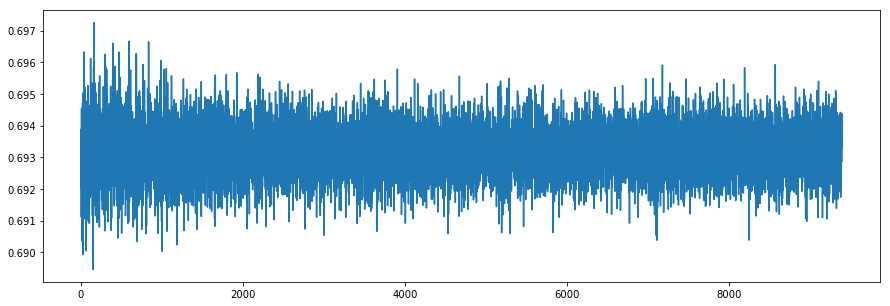

In [133]:
import matplotlib.pyplot as plt
from pylab import rcParams
%matplotlib inline
rcParams['figure.figsize'] = 15, 5


plt.plot(losses)

In [134]:
print(accuracy_score(labels_train, predictions_train))
print(accuracy_score(labels_test, predictions_test))

0.4890292553191489
0.5


In [135]:
from sklearn.metrics import confusion_matrix

confusion_matrix(labels_train, predictions_train)

array([[735, 806],
       [731, 736]])

In [136]:
confusion_matrix(labels_test, predictions_test)

array([[163, 221],
       [163, 221]])

In [137]:
accuracy_score(labels_test[::2], get_final_predictions(probabilities_test, threshold=1))

0.4635416666666667

In [123]:
0.6360235168359166 (neg_sam = 7)
attentionRNN = AttentionRNN(units, attention_units=10, num_classes=2, fc_layers=[], dropout_keep_proba=0.9, activation=tf.nn.relu)

predicted_labels_train, loss_train, log_probs_train = attentionRNN(train_X, train_y)
predicted_labels_test, loss_test, log_probs_test = attentionRNN(test_X, test_y)
    
0.6424371993586317 (neg_sam = 7)

attentionRNN = AttentionRNN(units, attention_units=10, num_classes=2, fc_layers=[64], dropout_keep_proba=0.9, activation=tf.nn.relu)

predicted_labels_train, loss_train, log_probs_train = attentionRNN(train_X, train_y)
predicted_labels_test, loss_test, log_probs_test = attentionRNN(test_X, test_y)

0.6397648316408338 (neg_sam = 7)
attentionRNN = AttentionRNN(units, attention_units=100, num_classes=2, fc_layers=[], dropout_keep_proba=0.9, activation=tf.nn.relu)

predicted_labels_train, loss_train, log_probs_train = attentionRNN(train_X, train_y)
predicted_labels_test, loss_test, log_probs_test = attentionRNN(test_X, test_y)

0 1
[0.25019684 0.7498032 ]
1 1
[0.25019684 0.7498032 ]
0 1
[0.25016373 0.74983627]
1 1
[0.25016373 0.74983627]
1 1
[0.2501894 0.7498106]
0 1
[0.2501894 0.7498106]
0 1
[0.25013044 0.7498695 ]
1 1
[0.25013044 0.7498695 ]
0 1
[0.25010857 0.74989146]
1 1
[0.25010857 0.74989146]


## Create skip thoughts embbedings (already done this once no need to do again)

In [2]:
from sklearn.metrics import accuracy_score
from sklearn.utils import shuffle

def get_batches(iterable, batch_size=64, do_shuffle=True):
    """
    Generate batches
    Parameters
    ----------
    iterable: list
        data to generate batches for
    batch_size: int
    do_shuffle: bool
        Whether to shuffle in each epoch
    """
    if do_shuffle:
        iterable = shuffle(iterable)

    length = len(iterable)
    for ndx in range(0, length, batch_size):
        iterable_batch = iterable[ndx: min(ndx + batch_size, length)]
        yield iterable_batch

In [3]:
# %%bash

# CWD=/cluster/project/infk/courses/machine_perception_19/Sasglentamekaiedo


# # Directory to download the pretrained models to.
# PRETRAINED_MODELS_DIR="${CWD}/skip_thoughts/pretrained/"

# mkdir -p ${PRETRAINED_MODELS_DIR}
# cd ${PRETRAINED_MODELS_DIR}

# # Download and extract the unidirectional model.
# wget "http://download.tensorflow.org/models/skip_thoughts_uni_2017_02_02.tar.gz"
# tar -xvf skip_thoughts_uni_2017_02_02.tar.gz
# rm skip_thoughts_uni_2017_02_02.tar.gz

# # Download and extract the bidirectional model.
# wget "http://download.tensorflow.org/models/skip_thoughts_bi_2017_02_16.tar.gz"
# tar -xvf skip_thoughts_bi_2017_02_16.tar.gz
# rm skip_thoughts_bi_2017_02_16.tar.gz

# %%bash

# DIRECTORY=/cluster/project/infk/courses/machine_perception_19/Sasglentamekaiedo/skip_thoughts_npy

# wget http://www.cs.toronto.edu/~rkiros/models/dictionary.txt --directory-prefix=${DIRECTORY}
# wget http://www.cs.toronto.edu/~rkiros/models/utable.npy --directory-prefix=${DIRECTORY}
# wget http://www.cs.toronto.edu/~rkiros/models/btable.npy --directory-prefix=${DIRECTORY}
# wget http://www.cs.toronto.edu/~rkiros/models/uni_skip.npz --directory-prefix=${DIRECTORY}
# wget http://www.cs.toronto.edu/~rkiros/models/uni_skip.npz.pkl --directory-prefix=${DIRECTORY}
# wget http://www.cs.toronto.edu/~rkiros/models/bi_skip.npz --directory-prefix=${DIRECTORY}
# wget http://www.cs.toronto.edu/~rkiros/models/bi_skip.npz.pkl --directory-prefix=${DIRECTORY}

In [4]:
from skip_thoughts import load_model, Encoder

In [5]:
# import skipthoughts

model = load_model()
encoder = Encoder(model)
# model = skipthoughts.load_model()
# encoder = skipthoughts.Encoder(model)

Loading model parameters...
Compiling encoders...


WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.


Loading tables...
Packing up...


In [6]:
import nltk
import numpy as np

nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     /cluster/home/sanagnos/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [13]:
len(data_val) * 6

11226

In [9]:
names = ['InputSentence' + str(i) for i in [1, 2, 3, 4]]
names.append('RandomFifthSentenceQuiz1')
names.append('RandomFifthSentenceQuiz2')
names

['InputSentence1',
 'InputSentence2',
 'InputSentence3',
 'InputSentence4',
 'RandomFifthSentenceQuiz1',
 'RandomFifthSentenceQuiz2']

In [11]:
all_senteces = data_val[names].values.reshape(-1)
all_senteces.shape

(11226,)

In [14]:
all_senteces_encoded = []

i = 0
batch_size = 2048
for sentences_batch in get_batches(all_senteces, batch_size=batch_size, do_shuffle=False):
    print('new batch', i)
    i += batch_size
    all_senteces_encoded.append(encoder.encode(sentences_batch, verbose=False))

new batch 0
new batch 2048
new batch 4096
new batch 6144
new batch 8192
new batch 10240


In [15]:
all_senteces_encoded_np = np.concatenate(all_senteces_encoded, axis=0)

In [17]:
all_senteces_encoded_np = all_senteces_encoded_np.reshape((-1, 6, 4800))
all_senteces_encoded_np

array([[[ 1.31560417e-04, -4.60474798e-03,  5.44821378e-03, ...,
         -1.27321417e-02,  1.50634372e-03, -1.27441005e-03],
        [-3.88688175e-04, -3.38627398e-02, -2.09803274e-03, ...,
         -2.37040762e-02,  6.28774520e-03,  6.22180570e-03],
        [ 7.84618035e-03,  2.99578756e-02, -3.70612345e-03, ...,
         -1.77556872e-02,  2.97994260e-03,  1.15354499e-02],
        [-2.13756808e-03, -9.57396440e-03, -2.61726649e-03, ...,
         -1.27650155e-02,  2.76875636e-03, -3.84200877e-03],
        [-7.14206742e-03, -2.27032006e-02,  1.57285631e-02, ...,
         -3.76864523e-03,  2.76917825e-03,  6.08157646e-03],
        [ 1.67411577e-03, -1.09987073e-02, -1.96930650e-03, ...,
         -3.17759626e-02,  2.28350190e-03,  6.21051714e-03]],

       [[ 3.60842608e-02,  4.32302430e-03,  1.93696190e-02, ...,
         -7.76809687e-03,  2.66928691e-03,  7.26393657e-03],
        [-8.56942497e-03, -5.56371734e-03,  1.18741076e-02, ...,
          1.73653606e-02,  2.12568906e-03, -5.12142

In [24]:
# import numpy as np

# np.save('/cluster/project/infk/courses/machine_perception_19/Sasglentamekaiedo/skip-thoughts-embbedings_validation.npy', all_senteces_encoded_np)